In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.multitest import multipletests

In [ ]:
# === Custom origin order for heatmap: these are the names of the 11 WT sequences ===
custom_origin_order = [
    "Os_LEA_or6", "syn_LEA_1", "Asyn_isoform_5", "A0A4D6M434", "A0A1U8F7A1",
    "At2g46140_tile7", "TgL_8x", "A0A438HAK2", "Os_LEA_or4",
    "CAHS_68135_tile4", "Os_LEA_or3__Kappa_up_2_"
]

In [ ]:
# === Step 1: Load Dataset ===
df1 = pd.read_csv('sequencing_data_all.csv')
df1['Sequence_ID'] = df1['Sequence_ID'].astype(str).str.strip()

In [ ]:
# === Step 2: Define features ===
nardini_cols = [col for col in df1.columns if col.startswith('nardini_') and (col.endswith('_zscore') or col.endswith('_raw'))]

other_features = [
    'cider_kappa', 'cider_omega', 'cider_delta', 'cider_length', 
    'cider_mean_net_charge', 'cider_fraction_neutral',
    'sparrow_SCD', 'sparrow_SHD', 'sparrow_complexity',
    'sparrow_scaled_rg', 'sparrow_scaled_re', 
    'sparrow_prefactor', 'sparrow_scaling_exponent', 'sparrow_asphericity'
]

new_feature_cols = [
    'avg_helix_prob', 'avg_beta_prob', 'avg_coil_prob',
    'avg_mito_targeting', 'avg_nes', 'avg_nis'
]

all_features = nardini_cols + other_features + new_feature_cols
chem_cols = [col for col in all_features if col in round_df.columns]

print(f"Found {len(nardini_cols)} nardini columns")
print(f"Total features to analyze: {len(chem_cols)}")

Found 108 nardini columns
Total features to analyze: 128


## Note: Step 5 will take some time with the monte carlo spearman r across all features

In [ ]:
# === Step 5: Spearman r Filtering ===
results = []
n_iter = 1000
min_n = 6
rng = np.random.default_rng(42)

for base in custom_origin_order:
    base_df = df1[(df1['base_origin'] == base) | (df1['Sequence_ID'] == original_id)].copy()
    original_id = f"original_sequence_-_{base}"
    original_row = df1[df1['Sequence_ID'] == original_id]

    if original_row.empty:
        print(f"Original sequence not found for base: {base}")
        continue

    for feat in chem_cols:
        if feat not in df1.columns or pd.isna(original_row[feat].values[0]):
            continue

        if not pd.api.types.is_numeric_dtype(df1[feat]):
            print(f"Skipping non-numeric feature: {feat}")
            continue

        original_value = original_row[feat].values[0]
        lower_bound = original_value * 0.93
        upper_bound = original_value * 1.07

        filtered_df = base_df[
            ((base_df[feat] < lower_bound) | (base_df[feat] > upper_bound)) |
            (base_df['Sequence_ID'] == original_id)
        ].dropna(subset=[feat, 'calculated_avg', 'calculated_std'])

        if len(filtered_df) < min_n:
            print(f"Skipping {base} - {feat}: n={len(filtered_df)} < {min_n}")
            continue

        r_vals = []
        slope_vals = []
        for _ in range(n_iter):
            sample = filtered_df.sample(frac=1, replace=True, random_state=rng.integers(1e9))
            if sample[feat].nunique() > 1 and sample['calculated_avg'].nunique() > 1:
                r = sample[feat].corr(sample['calculated_avg'], method='spearman')
                if pd.notnull(r):
                    r_vals.append(r)
                slope, _, _, _, _ = stats.linregress(sample[feat], sample['calculated_avg'])
                if pd.notnull(slope):
                    slope_vals.append(slope)

        if r_vals:
            r_full, p_full = stats.spearmanr(filtered_df[feat], filtered_df['calculated_avg'])
            r_array = np.array(r_vals)
            bootstrap_p = 2 * min(np.mean(r_array > 0), np.mean(r_array < 0))
            bootstrap_p = max(bootstrap_p, 1/n_iter)
            
            results.append({
                'base_origin': base,
                'feature': feat,
                'r_mean': np.mean(r_vals),
                'r_std': np.std(r_vals),
                'slope_mean': np.mean(slope_vals) if slope_vals else np.nan,
                'slope_std': np.std(slope_vals) if slope_vals else np.nan,
                'p_value': p_full,
                'bootstrap_p': bootstrap_p,
                'n_samples': len(filtered_df),
                'mean_calculated_std': filtered_df['calculated_std'].mean()
            })


# === Step 6: Apply FDR correction and save results ===
results_df = pd.DataFrame(results)

_, pvals_adj, _, _ = multipletests(results_df['p_value'], method='fdr_bh')
results_df['p_adj'] = pvals_adj
results_df['neg_log10_padj'] = -np.log10(results_df['p_adj'].clip(lower=1e-300))

_, bootstrap_pvals_adj, _, _ = multipletests(results_df['bootstrap_p'], method='fdr_bh')
results_df['bootstrap_p_adj'] = bootstrap_pvals_adj
results_df['neg_log10_bootstrap_padj'] = -np.log10(results_df['bootstrap_p_adj'].clip(lower=1e-300))

results_df.to_csv('spearman_complete_results.csv', index=False)

print(f"Total correlations calculated: {len(results_df)}")
print(f"Significant (p_adj < 0.05): {(results_df['p_adj'] < 0.05).sum()}")
print(f"Sample size statistics:")
print(results_df['n_samples'].describe())

Skipping Os_LEA_or6 - nardini_Frac W_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_Hydrophobicity_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_C Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_D Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_F Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_G Patch_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_H Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_I Patch_raw: n=1 < 6
Skipping Os_LEA_or6 - nardini_L Patch_raw: n=1 < 6
Skipping Os_LEA_or6 - nardini_M Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_N Patch_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_P Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_Q Patch_raw: n=3 < 6
Skipping Os_LEA_or6 - nardini_T Patch_raw: n=1 < 6
Skipping Os_LEA_or6 - nardini_V Patch_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_Y Patch_raw: n=0 < 6
Skipping Os_LEA_or6 - nardini_RG Frac_raw: n=2 < 6
Skipping Os_LEA_or6 - nardini_Frac C_zscore: n=1 < 6
Skipping Os_LEA_or6 - nardini_Frac H_zscore: n=3 < 6
Skipping Os_LEA_or6 -

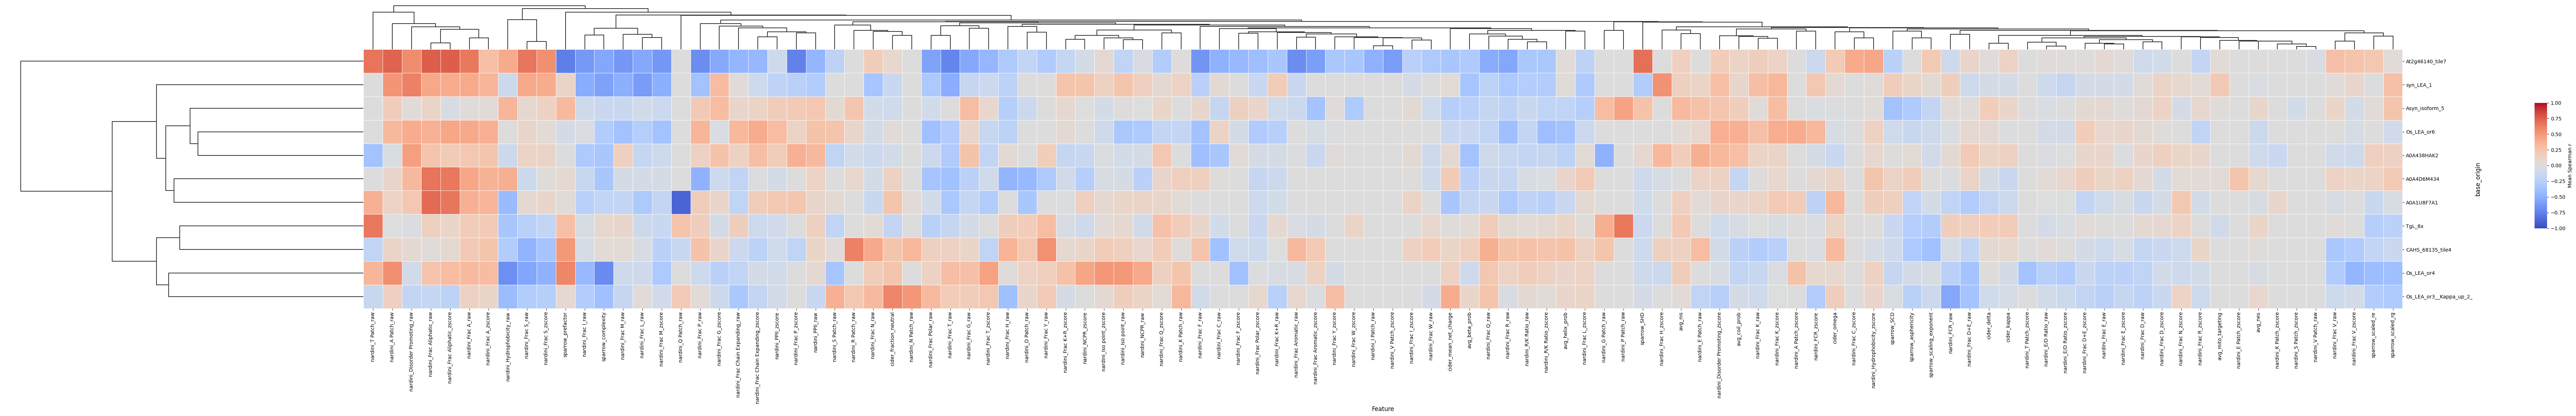

Creating slope heatmap...


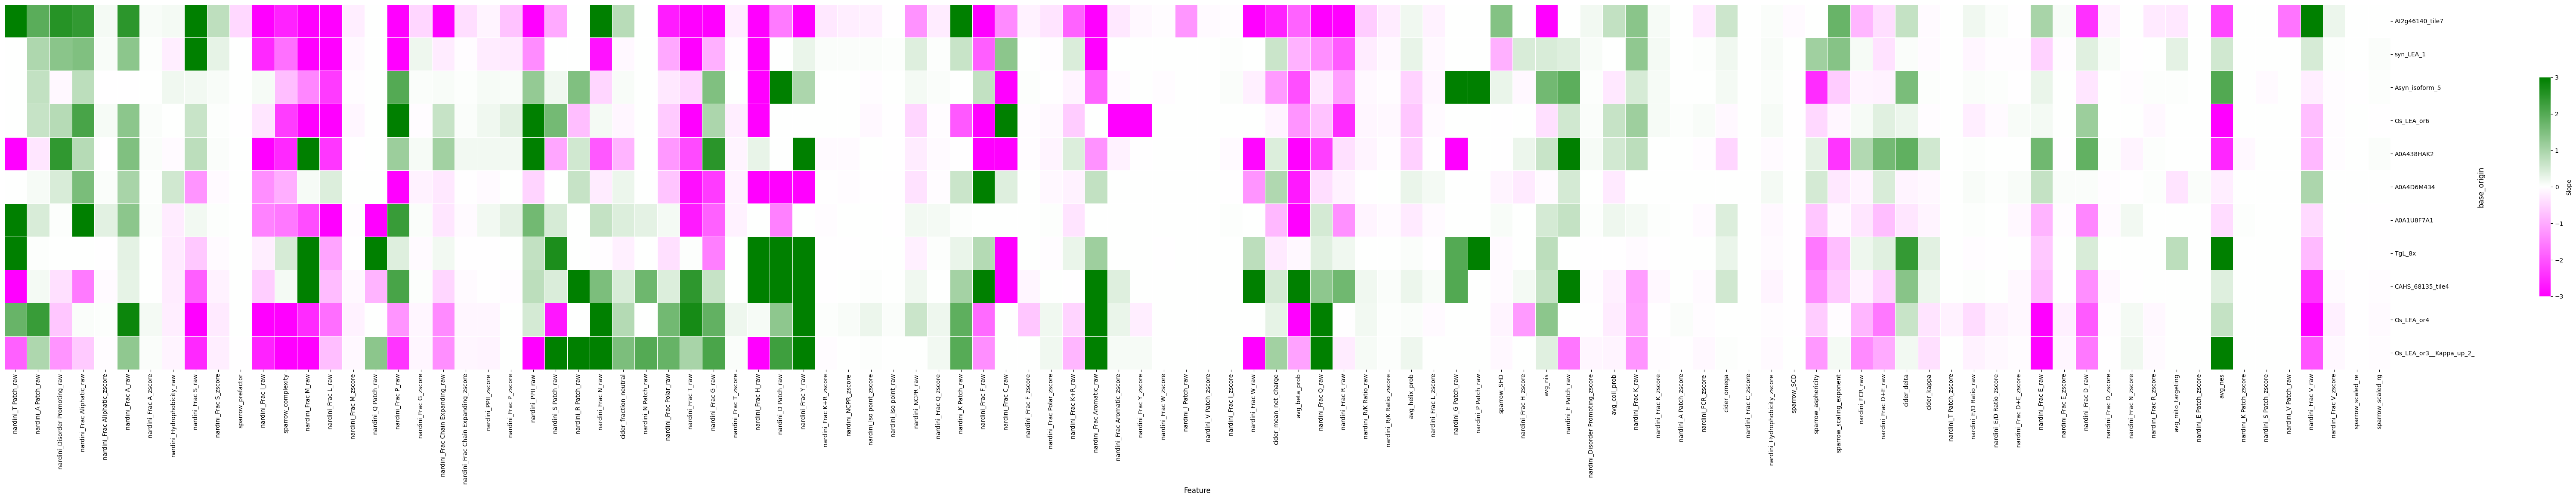

Creating bootstrap significance heatmap...


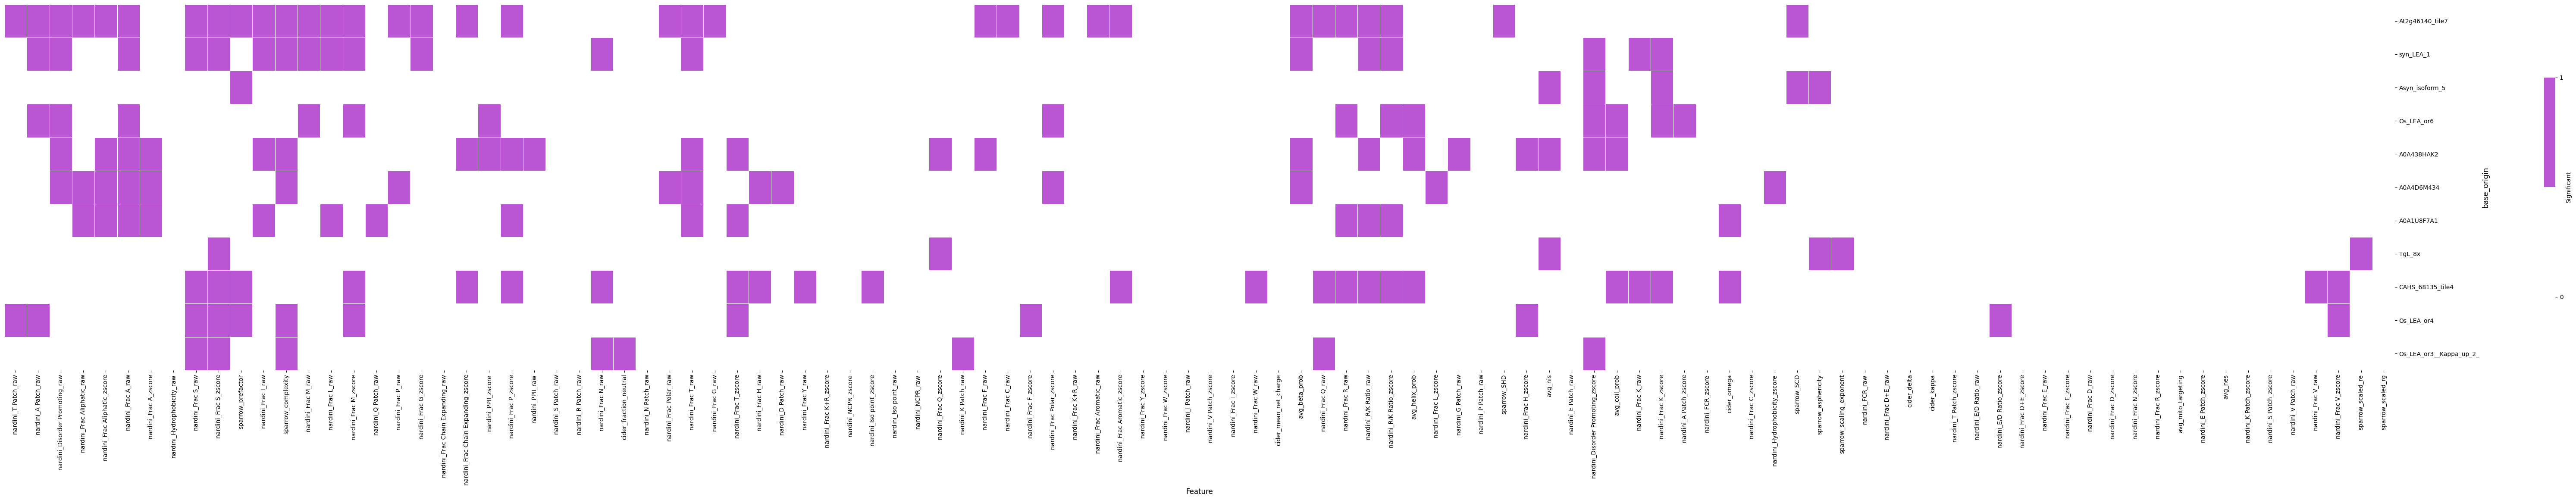

In [40]:
# === Step 7: Create clustered heatmap ===
heatmap_df = results_df.pivot(index='feature', columns='base_origin', values='r_mean')
heatmap_df = heatmap_df[custom_origin_order]
heatmap_df_clean = heatmap_df.dropna(how='all')
heatmap_df_transposed = heatmap_df_clean.T
heatmap_df_for_clustering = heatmap_df_transposed.fillna(0)

fig_width = len(heatmap_df_clean)*0.6 + 6
fig_height = len(custom_origin_order)*0.7 + 4

g = sns.clustermap(
    heatmap_df_for_clustering,
    cmap='coolwarm',
    center=0, vmin=-1, vmax=1,
    figsize=(fig_width, fig_height),
    linewidths=0.5,
    cbar_kws={'label': 'Mean Spearman r'},
    annot=False,
    method='average', metric='euclidean',
    tree_kws=dict(linewidths=1.5),
    row_cluster=True, col_cluster=True,
    dendrogram_ratio=0.15,
    cbar_pos=(1.02, 0.45, 0.005, 0.3) 
)

g.ax_heatmap.set_xlabel('Feature', fontsize=12)
g.ax_heatmap.yaxis.set_ticks_position('right')
g.ax_heatmap.yaxis.set_label_position('right')
g.ax_heatmap.set_ylabel('base_origin', fontsize=12)

clustered_row_order = g.dendrogram_row.reordered_ind
clustered_col_order = g.dendrogram_col.reordered_ind
row_labels = heatmap_df_for_clustering.index[clustered_row_order]
col_labels = heatmap_df_for_clustering.columns[clustered_col_order]

plt.savefig('spearman_combined_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

# === Step 7b: Slope/Amplitude Heatmap ===
print("Creating slope heatmap...")
magenta_white_green = LinearSegmentedColormap.from_list('magenta_white_green', ['magenta', 'white', 'green'])

slope_heatmap = results_df.pivot(index='feature', columns='base_origin', values='slope_mean')
slope_heatmap_T = slope_heatmap.T.fillna(0)
slope_heatmap_ordered = slope_heatmap_T.reindex(index=row_labels, columns=col_labels)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(slope_heatmap_ordered, cmap=magenta_white_green, center=0, vmin=-3, vmax=3,
            linewidths=0.5, cbar_kws={'label': 'Slope', 'shrink': 0.6}, annot=False, ax=ax)
ax.set_xlabel('Feature', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
ax.set_ylabel('base_origin', fontsize=12)
plt.tight_layout()
plt.savefig('slope_amplitude_combined_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

# === Step 7e: Bootstrap Significance Heatmap (Binary) ===
print("Creating bootstrap significance heatmap...")
from matplotlib.colors import ListedColormap

# Create binary significance matrix (1 = significant, 0 = not significant)
results_df['is_significant'] = (results_df['bootstrap_p_adj'] < 0.05).astype(int)

sig_heatmap = results_df.pivot(index='feature', columns='base_origin', values='is_significant')
sig_heatmap_T = sig_heatmap.T.fillna(0)
sig_heatmap_ordered = sig_heatmap_T.reindex(index=row_labels, columns=col_labels)

# Binary colormap: white (0) and purple (1)
binary_cmap = ListedColormap(['white', 'mediumorchid'])

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(sig_heatmap_ordered, cmap=binary_cmap, vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={'label': 'Significant', 'shrink': 0.6, 'ticks': [0, 1]}, 
            annot=False, ax=ax)
ax.set_xlabel('Feature', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
ax.set_ylabel('base_origin', fontsize=12)
plt.tight_layout()
plt.savefig('bootstrap_significance_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

## Optional: plot trends with specified correlations

This will iterate through all WT sequences across all features. 

Includes +/- 7% Filtering around WT:
```lower_bound = original_value * 0.93```
```upper_bound = original_value * 1.07```

WT sequence is highlighted in red, all other GOOSE modified variants in blue.


📈 Plotting correlations with |r| >= 0.6...


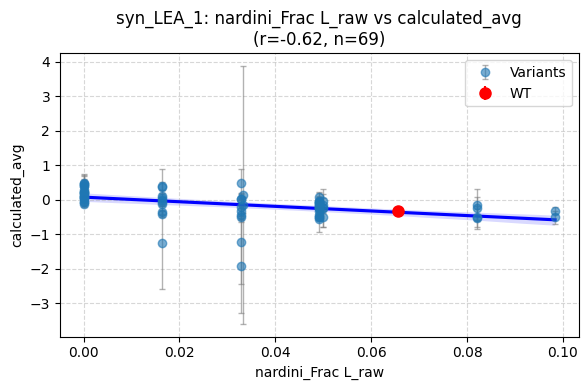

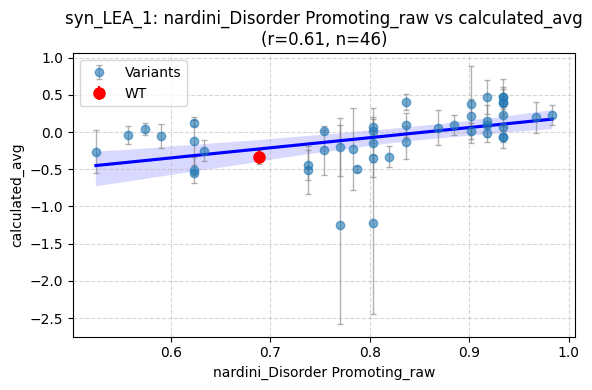

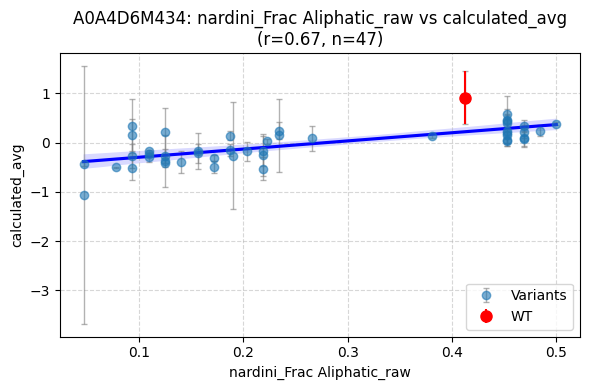

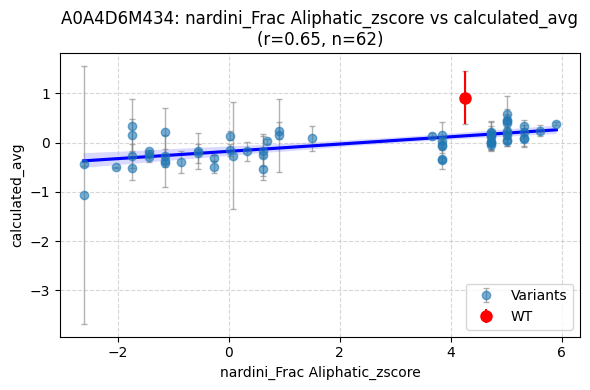

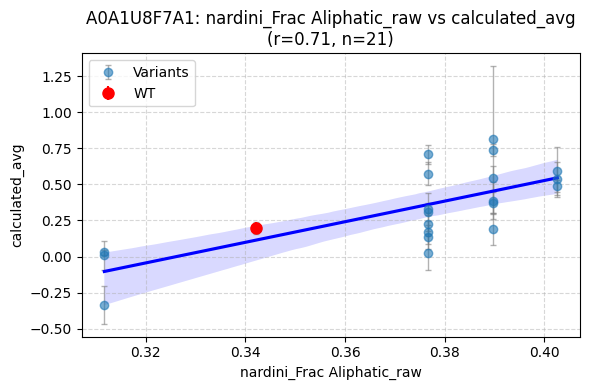

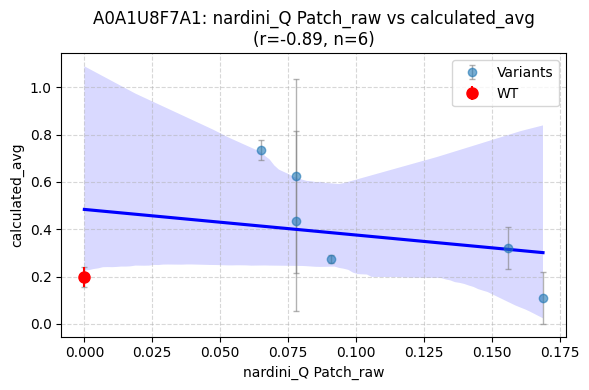

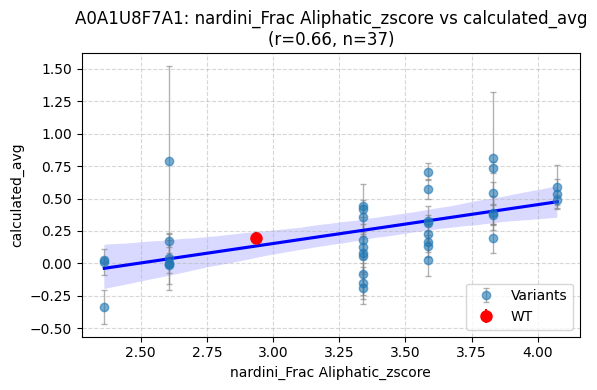

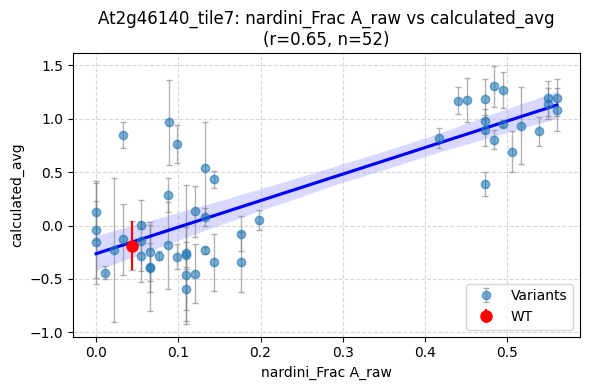

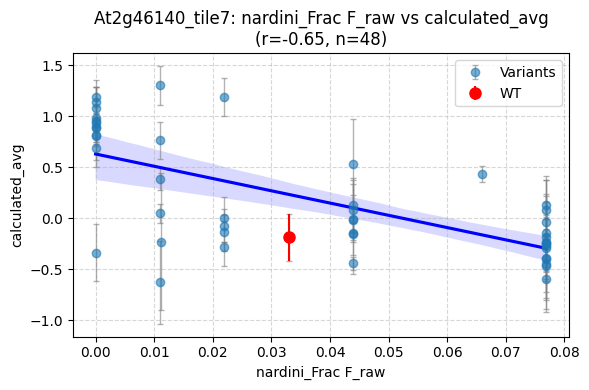

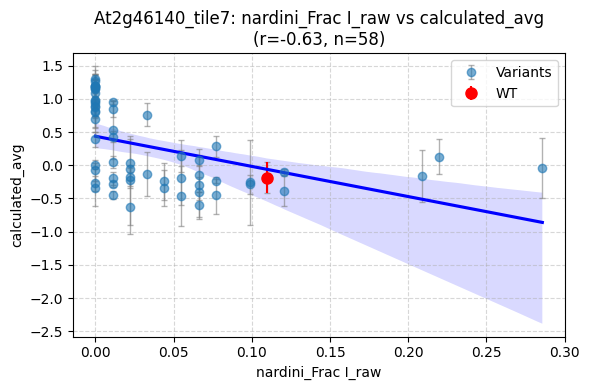

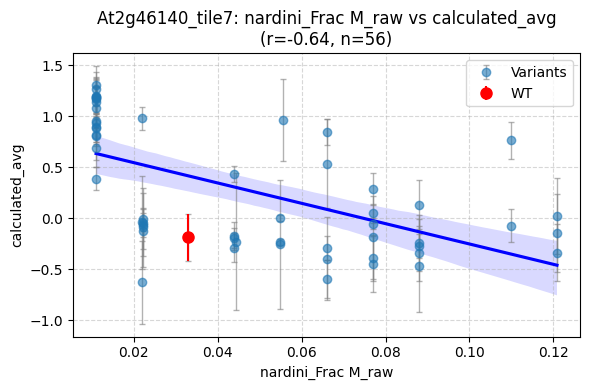

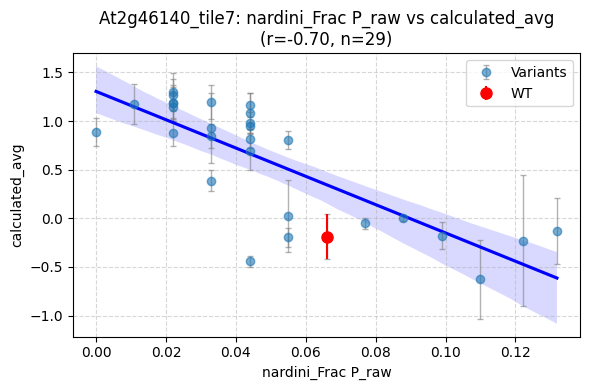

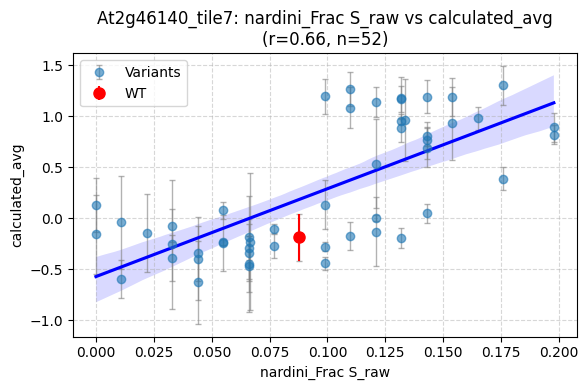

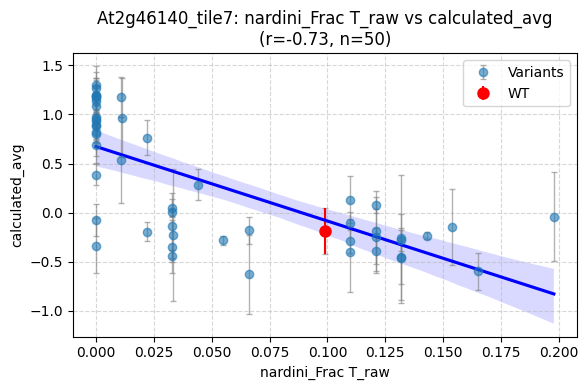

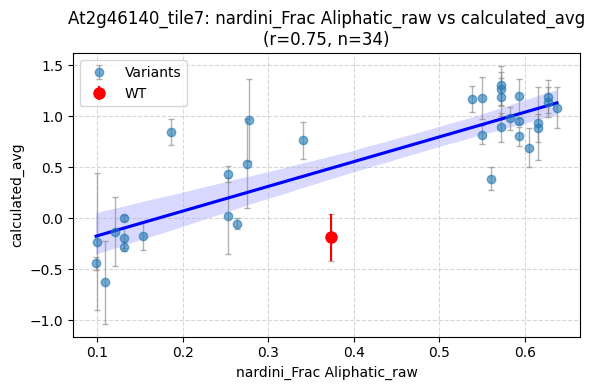

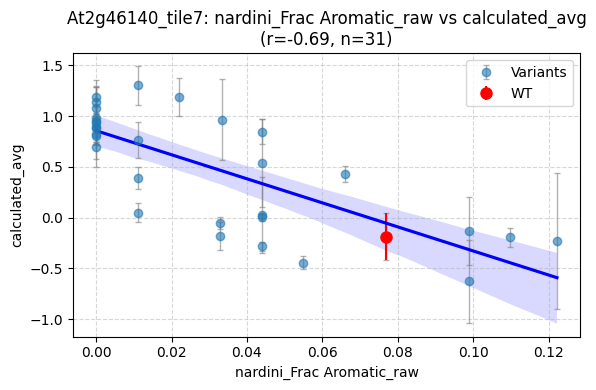

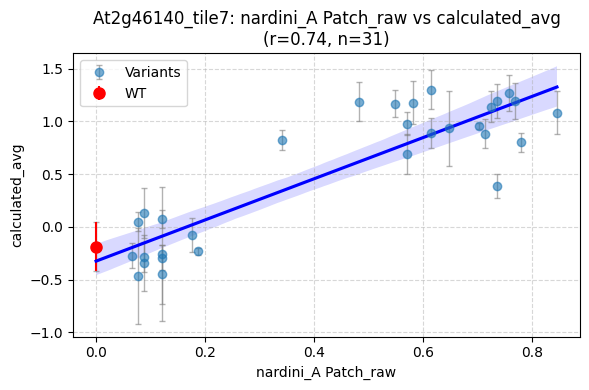

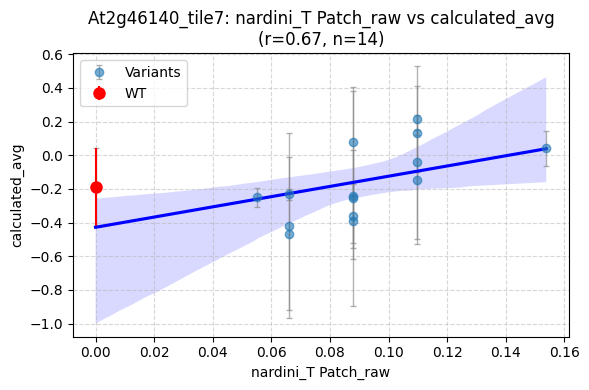

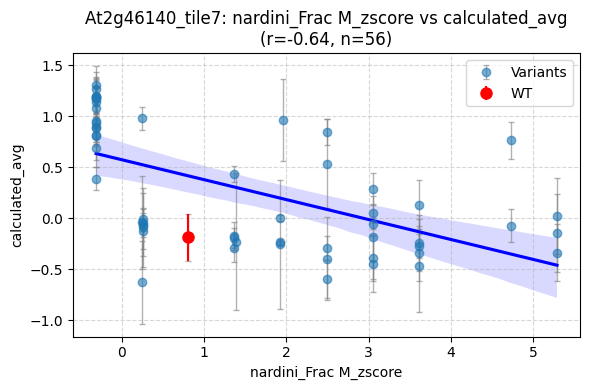

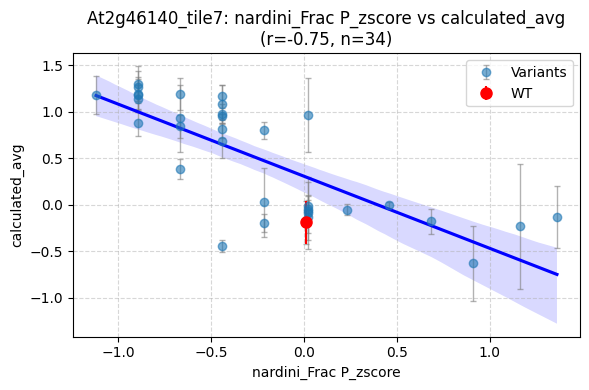

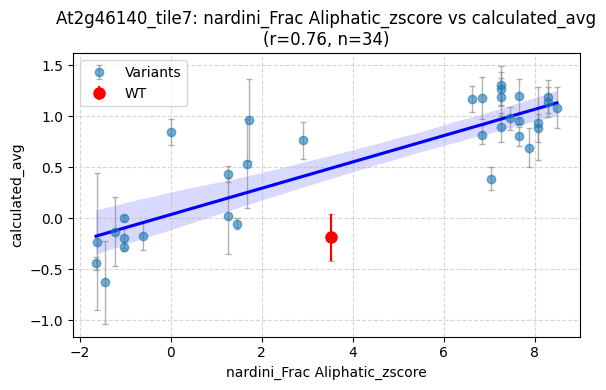

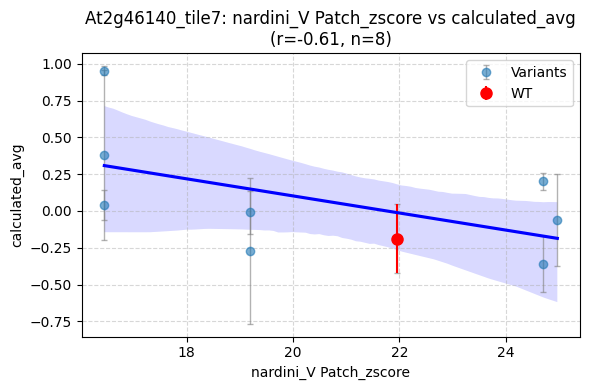

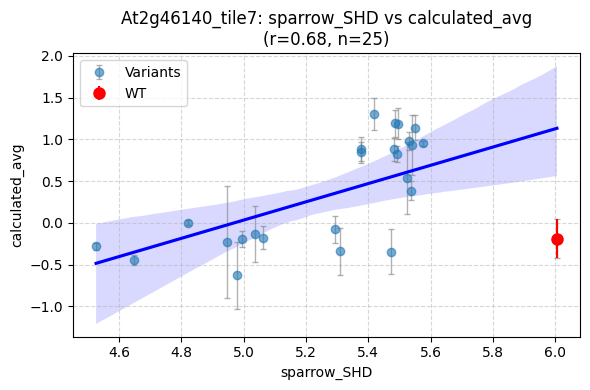

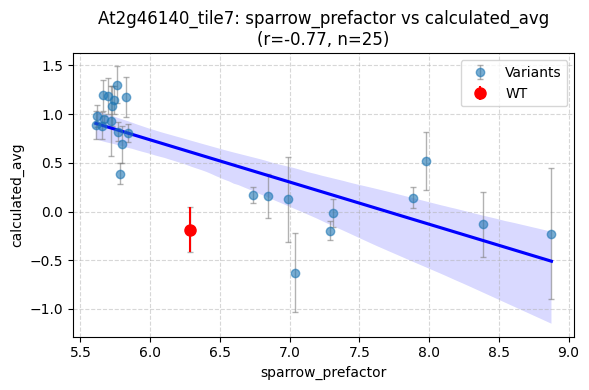

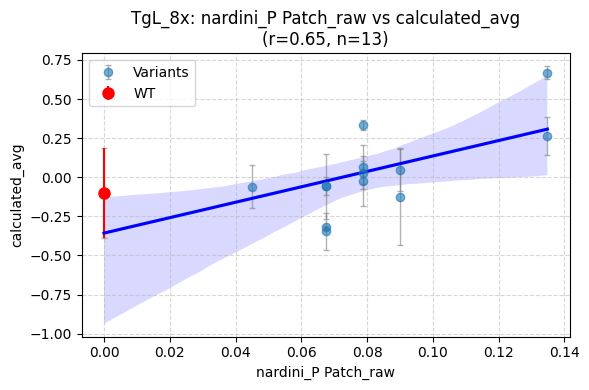

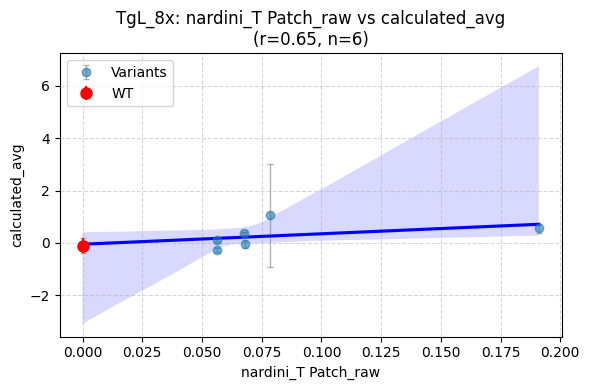

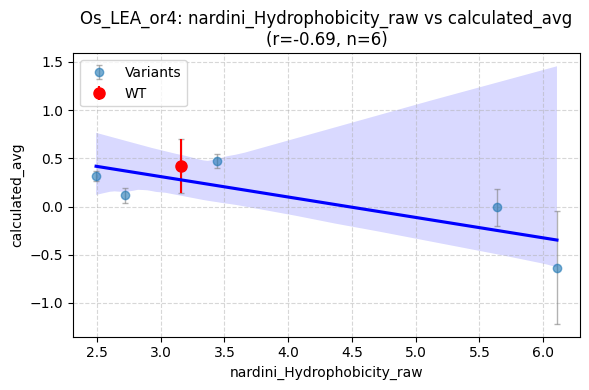

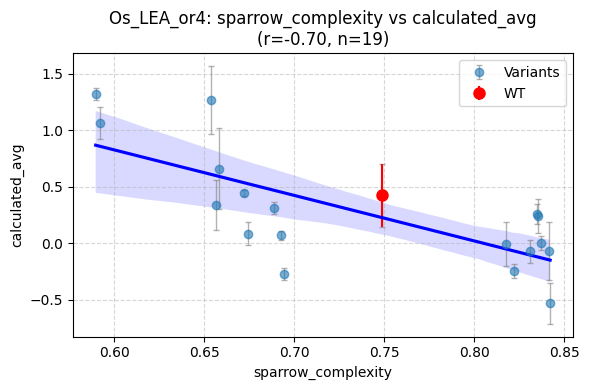

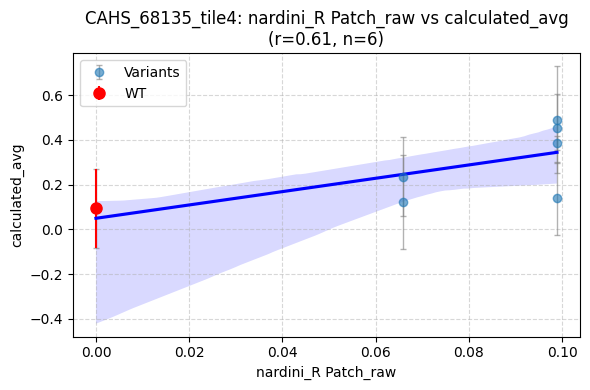

Generated 29 scatter plots for correlations with |r| >= 0.6


In [38]:
# === Step 8: Plot significant scatterplots (|r| >= 0.6) ===
print(f"\n📈 Plotting correlations with |r| >= 0.6...")
plot_count = 0

for _, row in results_df.iterrows():
    if abs(row['r_mean']) >= 0.6:
        base = row['base_origin']
        feat = row['feature']
        original_id = f"original_sequence_-_{base}"
        original_row = df1[df1['Sequence_ID'] == original_id]

        if original_row.empty or pd.isna(original_row[feat].values[0]):
            continue

        original_value = original_row[feat].values[0]
        lower_bound = original_value * 0.93
        upper_bound = original_value * 1.07

        plot_df = df1[
            ((df1['base_origin'] == base) | (df1['Sequence_ID'] == original_id)) &
            ((df1['Sequence_ID'] == original_id) | 
             ((df1[feat] < lower_bound) | (df1[feat] > upper_bound)))
        ].dropna(subset=[feat, 'calculated_avg', 'calculated_std'])

        if plot_df.shape[0] < min_n:
            continue

        plt.figure(figsize=(6, 4))
        plt.errorbar(plot_df[feat], plot_df['calculated_avg'], yerr=plot_df['calculated_std'], 
                     fmt='o', alpha=0.6, ecolor='gray', elinewidth=1, capsize=2, label='Variants')

        if not original_row.empty:
            wt_se = original_row['calculated_std'].values[0] if pd.notna(original_row['calculated_std'].values[0]) else 0
            plt.errorbar(original_row[feat], original_row['calculated_avg'], yerr=wt_se, 
                         fmt='o', color='red', markersize=8, label='WT')

        sns.regplot(x=feat, y='calculated_avg', data=plot_df, scatter=False, ci=95, 
                    color='blue', line_kws={'label': 'Fit'})

        plt.xlabel(feat)
        plt.ylabel('calculated_avg')
        plt.title(f'{base}: {feat} vs calculated_avg\n(r={row["r_mean"]:.2f}, n={row["n_samples"]})')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        #plt.savefig(f'scatter_{base}_{feat}.svg', format='svg', bbox_inches='tight') ##uncomment if you want to save all (|r| >= 0.6) plots
        plt.show()
        plot_count += 1

print(f"Generated {plot_count} scatter plots for correlations with |r| >= 0.6")


📊 Creating significance overlay mask...


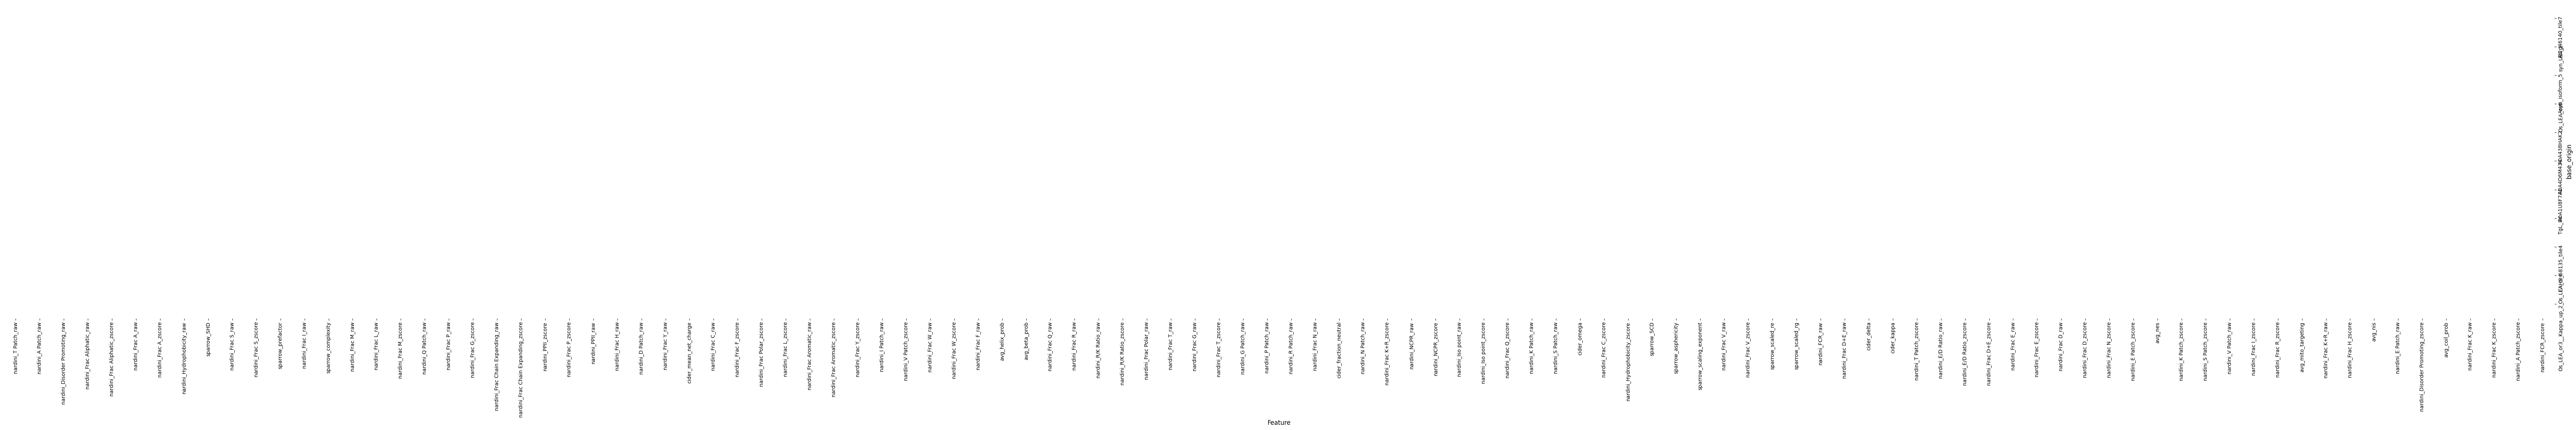

In [22]:
# === Step 7f: Bootstrap Significance Overlay (white=non-sig, transparent=sig) ===
print("\n📊 Creating significance overlay mask...")

# Create mask: 1 = non-significant (white), 0 = significant (transparent)
results_df['is_nonsignificant'] = (results_df['bootstrap_p_adj'] >= 0.05).astype(int)

nonsig_heatmap = results_df.pivot(index='feature', columns='base_origin', values='is_nonsignificant')
nonsig_heatmap_T = nonsig_heatmap.T.fillna(1)  # NaN = not tested = mask as white
nonsig_heatmap_ordered = nonsig_heatmap_T.reindex(index=row_labels, columns=col_labels).fillna(1)

# Colormap: transparent (0) and white (1)
overlay_cmap = ListedColormap([(1, 1, 1, 0), (1, 1, 1, 1)])  # RGBA: transparent, white

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(nonsig_heatmap_ordered, cmap=overlay_cmap, vmin=0, vmax=1,
            linewidths=0.5, cbar=False, annot=False, ax=ax)
ax.set_xlabel('Feature', fontsize=12)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
ax.set_ylabel('base_origin', fontsize=12)
plt.tight_layout()
plt.savefig('bootstrap_significance_overlay.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()